# CoexpressDeconvolve

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

import time
a = time.time()

In [2]:
def ReadVisium(path):
    from scipy.io import mmread
    Barcodes = pd.read_csv(f"{path}/filtered_feature_bc_matrix/barcodes.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Barcodes = Barcodes.iloc[:, 0]
    Features = pd.read_csv(f"{path}/filtered_feature_bc_matrix/features.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Features = Features.iloc[:, 1]
    Matrix = mmread(f"{path}/filtered_feature_bc_matrix/matrix.mtx.gz")
    from scipy import sparse
    Matrix = Matrix.transpose()
    Visium = pd.DataFrame.sparse.from_spmatrix(Matrix, columns=Features)
    Visium.set_index(Barcodes, inplace=True)
    Visium.index.names = ['Barcodes']
    return Visium

def ReadPositionsVisiumSD(path):
    Positions = pd.read_csv(f"{path}/spatial/tissue_positions.csv")
    Positions.set_index("barcode", inplace = True)
    Positions.index.names = ['Barcodes']
    return Positions

def DeconvolveCellTypes(Visium, df_clusters):

    cluster_sums = []

    for idx, gene_list in df_clusters.iloc[:, 0].items():
        # Filter for genes present in the expression data
        valid_genes = [gene for gene in gene_list if gene in Visium.index]
        # Sum expression values for these genes
        cluster_sum = Visium.loc[valid_genes].sum(axis=0)
        # Append result as a new row
        cluster_sums.append(cluster_sum)

    # Convert to DataFrame
    cluster_sum_df = pd.DataFrame(cluster_sums, index=df_clusters.index, columns=Visium.columns)
    return cluster_sum_df

def fit_negative_binomial(data):
    mean_val = np.mean(data)
    var_val = np.var(data)
    
    if var_val > mean_val: 
        r_est = mean_val ** 2 / (var_val - mean_val) 
        p_est = mean_val / var_val  
    else:
        r_est, p_est = np.nan, np.nan 
    
    return r_est, p_est

def VisiumUMISumPerGene(path):
    Features = pd.read_csv(f"{path}/filtered_feature_bc_matrix/features.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Features = Features.iloc[:, 1]
    from scipy.io import mmread
    Matrix = mmread(f"{path}/filtered_feature_bc_matrix/matrix.mtx.gz")
    from scipy.sparse import csr_matrix
    sdf = csr_matrix(Matrix, dtype='int8')
    UMI_sum = pd.DataFrame(sdf.sum(axis=1))
    UMI_sum.set_index(Features, inplace=True)
    UMI_sum.index.names = ['Features']
    UMI_sum.rename(columns={0:'Feature Counts in Spots Under Tissue'}, inplace=True)
    return UMI_sum

In [3]:
tissue_positions_data = ReadPositionsVisiumSD(".")

# Rotate Image
# Swap x and y
# tissue_positions_data = tissue_positions_data.rename(columns={'pxl_row_in_fullres': 'pxl_col_in_fullres', 'pxl_col_in_fullres': 'pxl_row_in_fullres'})

# 1st mirror
# tissue_positions_data['pxl_col_in_fullres'] = -(tissue_positions_data['pxl_col_in_fullres']-tissue_positions_data['pxl_col_in_fullres'].max()) 
# 2nd mirror
# tissue_positions_data['pxl_row_in_fullres'] = -(tissue_positions_data['pxl_row_in_fullres']-tissue_positions_data['pxl_row_in_fullres'].max()) 
tissue_positions_data.head()

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
Barcodes,,,,,
GTCACTTCCTTCTAGA-1,1,0,0,4550,15271
CACGGTCTCCTTACGA-1,1,0,2,4552,15088
ATAGCTGCGGATAAGA-1,1,0,4,4553,14905
GTCAGTATGTCCGGCG-1,1,0,6,4554,14723
ATGTACCAGTTACTCG-1,1,0,8,4556,14540


In [4]:
Visium = ReadVisium(".")
Visium.rename_axis("Gene", axis=1,inplace=True)
Visium = Visium.T
Visium

Barcodes,AACACCTACTATCGAA-1,AACACGTGCATCGCAC-1,AACACTTGGCAAGGAA-1,AACAGGAAGAGCATAG-1,AACAGGATTCATAGTT-1,AACAGGCCAACGATTA-1,AACAGGTTATTGCACC-1,AACAGGTTCACCGAAG-1,AACAGTCAGGCTCCGC-1,AACAGTCCACGCGGTG-1,...,TGTTCGCAACCGCCAA-1,TGTTCGTGACCAGTAG-1,TGTTCTGCTCTGTCGT-1,TGTTGCGTCCAAGATT-1,TGTTGGAACCTTCCGC-1,TGTTGGAACGAGGTCA-1,TGTTGGAAGCTCGGTA-1,TGTTGGATGGACTTCT-1,TGTTGGCCAGACCTAC-1,TGTTGGCCTACACGTG-1
Gene,,,,,,,,,,,,,,,,,,,,,
SAMD11,0,2,1,0,0,0,0,0,6,1,...,0,0,0,0,0,0,2,7,0,0
NOC2L,0,0,3,0,0,1,0,2,7,1,...,1,0,0,0,0,1,4,4,0,1
KLHL17,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,2,0,0
PLEKHN1,0,0,1,0,0,0,0,1,2,0,...,0,0,2,0,0,0,0,0,0,1
PERM1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,57,37,84,31,53,27,98,314,662,433,...,11,3,77,50,36,33,156,683,36,57
MT-ND4,57,24,99,23,38,20,66,286,655,275,...,19,11,61,51,29,36,130,621,30,53
MT-ND5,20,3,16,9,8,3,17,44,104,43,...,14,2,22,20,5,4,42,102,15,10


In [5]:
# Make sure to trim the genes with the low expression! This usually results in the 8-10K genes retained

Metrics = VisiumUMISumPerGene('.')

Metrics = Metrics[~Metrics.index.str.startswith((
                                                 'MT-', 
                                                 # 'LINC',
                                                 # 'MIR', 
                                                 'RP'
))]
Metrics.drop(Metrics[Metrics['Feature Counts in Spots Under Tissue'] < 1000].index, inplace=True)
# Metrics.drop(Metrics[Metrics['Feature Counts in Spots Under Tissue'] > 50000].index, inplace=True)

Metrics

,Feature Counts in Spots Under Tissue
Features,
SAMD11,5764
NOC2L,8559
KLHL17,1849
PLEKHN1,2749
HES4,9209
...,...
VBP1,8895
RAB39B,1215
CLIC2,3246


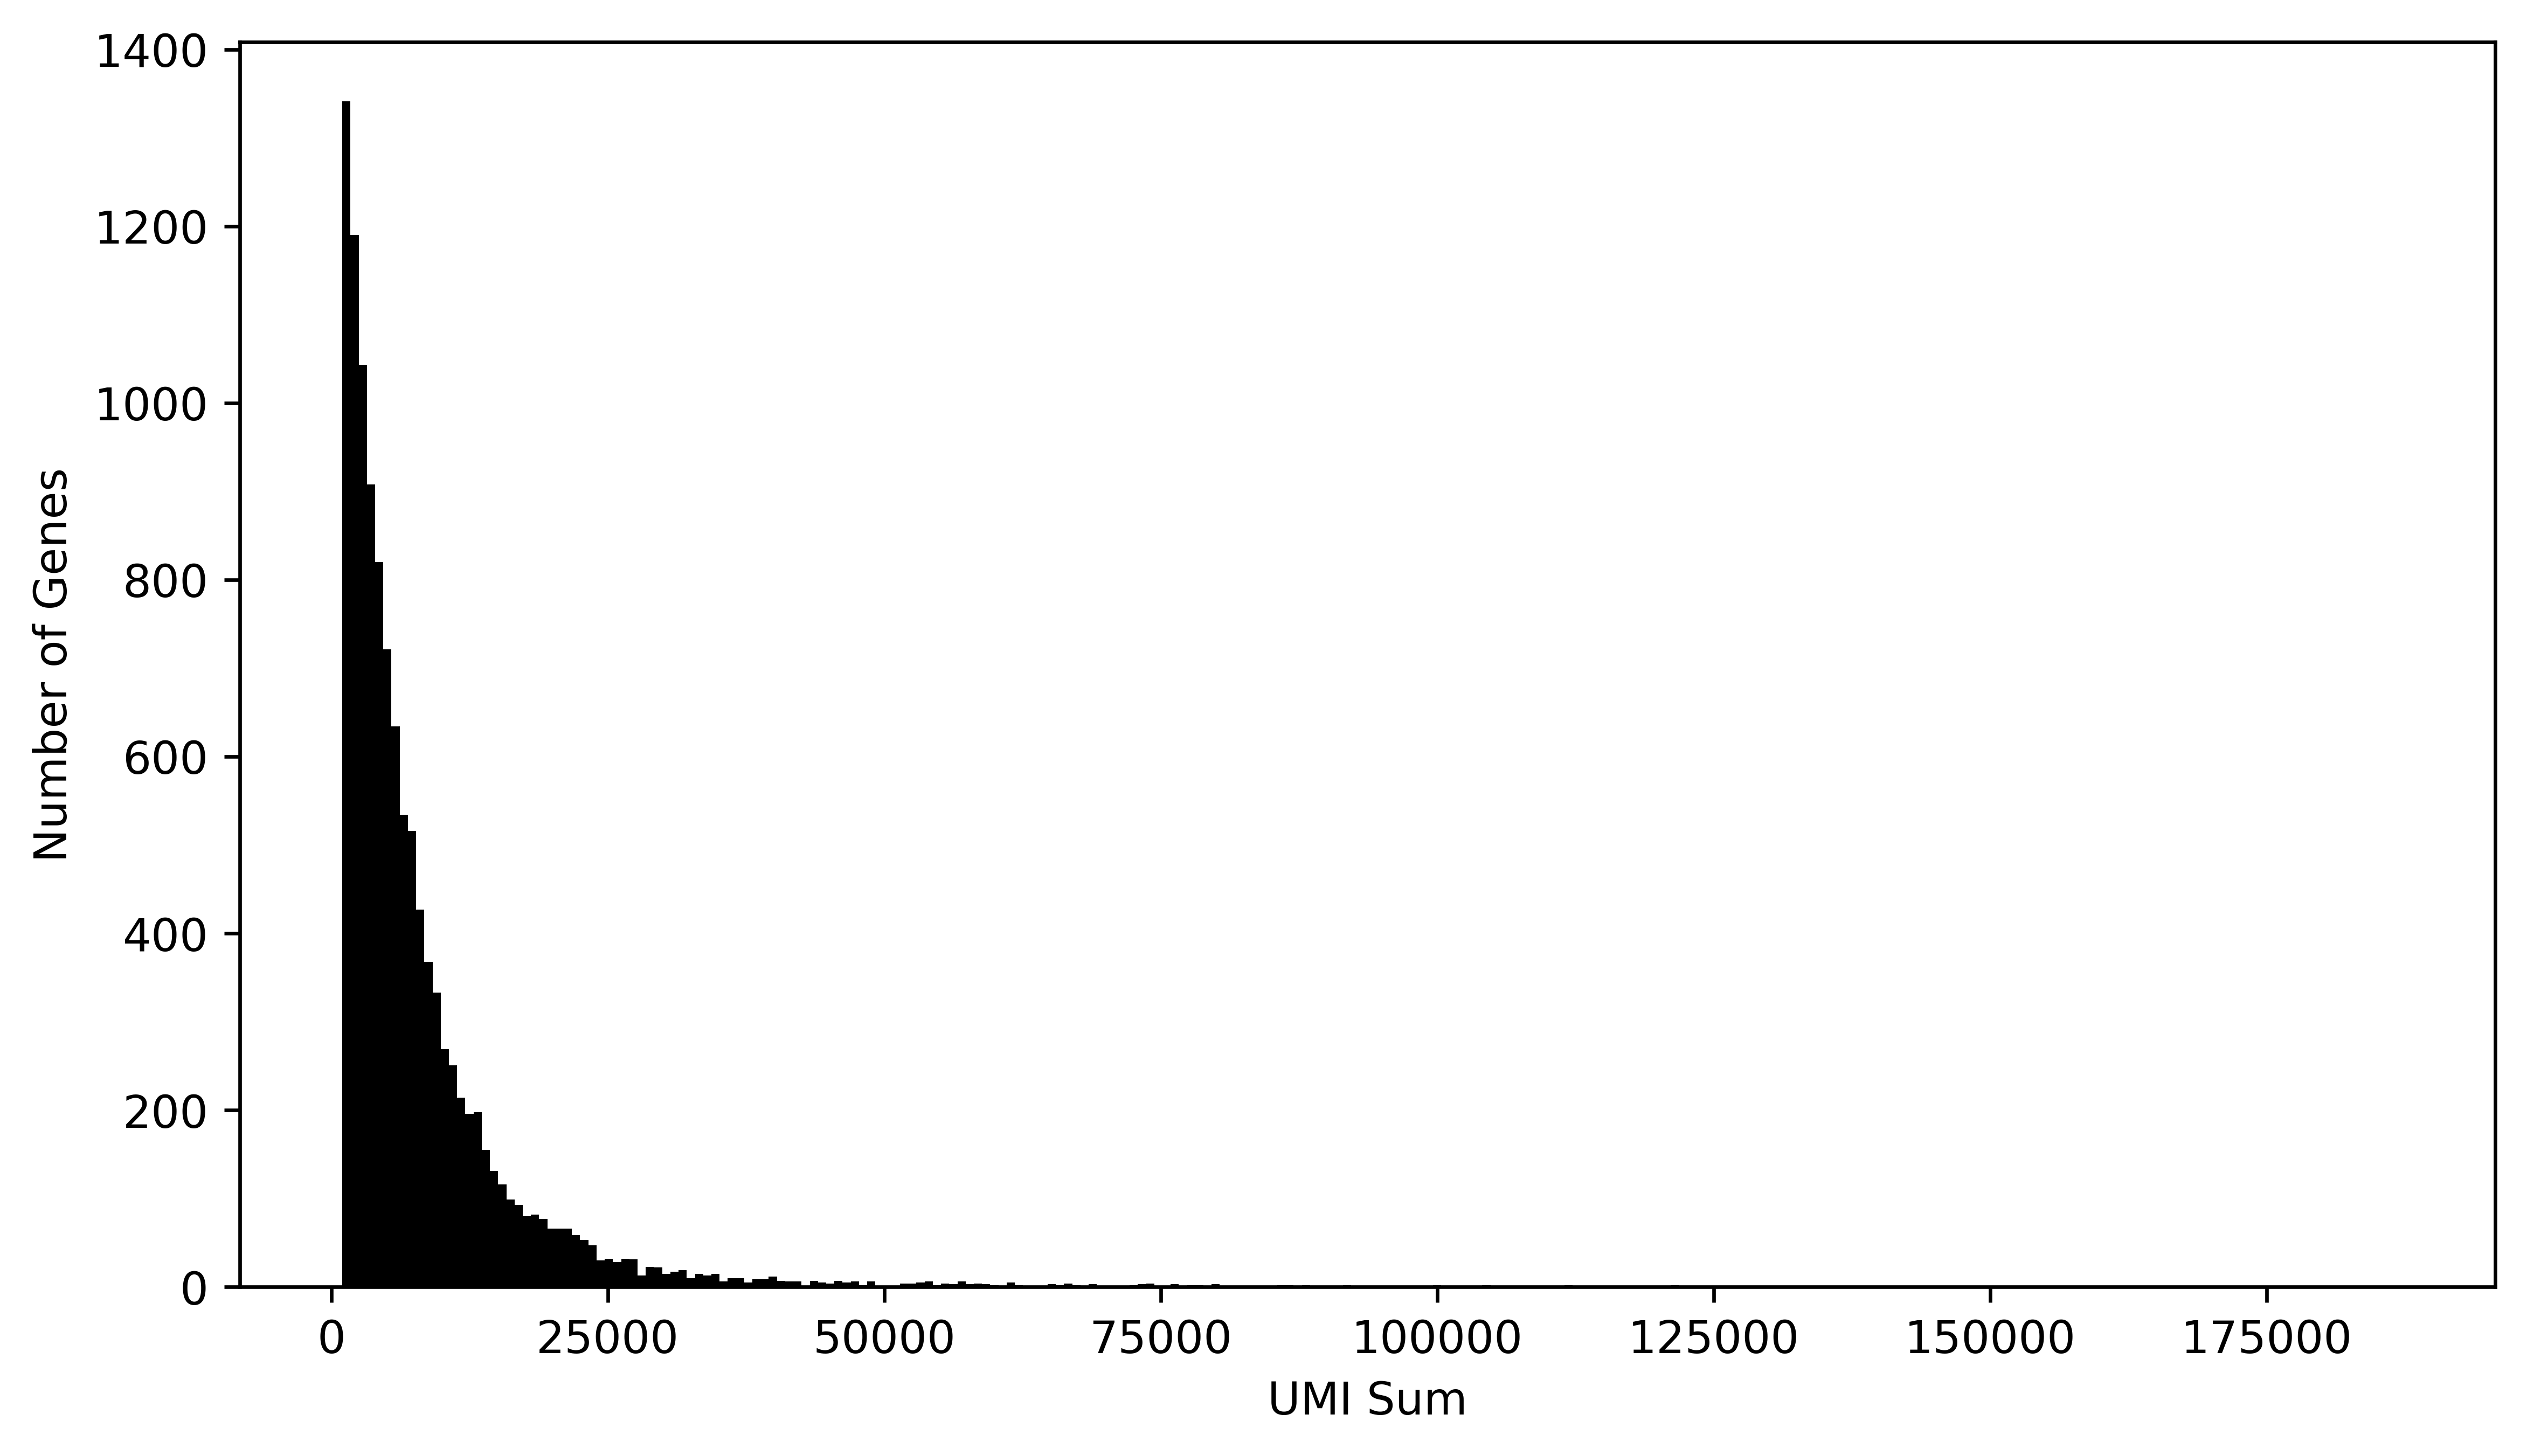

In [6]:
plt.figure(figsize=(9,5), dpi=600)
n_bins = 250
plt.hist(Metrics['Feature Counts in Spots Under Tissue'], n_bins, color='black')
plt.xlabel('UMI Sum')
plt.ylabel('Number of Genes')
plt.show()

In [7]:
# Replace non 0 with 1 to get rid of the GEX levels
Visium_Corr = Visium.where(Visium == 0, 1)
# Visium_Corr = Visium
Visium_Corr = Visium_Corr[Visium_Corr.index.isin(Metrics.index)]
Visium_Corr = Visium_Corr.T
Visium_Corr.head()

Gene,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,C1orf159,SDF4,B3GALT6,...,MPP1,F8A1,FUNDC2,CMC4,BRCC3,VBP1,RAB39B,CLIC2,TMLHE,VAMP7
Barcodes,,,,,,,,,,,,,,,,,,,,,
AACACCTACTATCGAA-1,0,0,0,0,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,1
AACACGTGCATCGCAC-1,1,0,0,0,0,0,1,0,1,1,...,1,1,1,0,0,0,0,0,0,1
AACACTTGGCAAGGAA-1,1,1,0,1,1,1,1,0,1,1,...,1,0,0,0,0,1,0,1,1,1
AACAGGAAGAGCATAG-1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
AACAGGATTCATAGTT-1,0,0,0,0,1,1,1,0,1,0,...,1,0,0,1,0,0,0,0,0,1


In [8]:
# Perform gene corr analysis

def fast_gene_correlation(df: pd.DataFrame) -> pd.DataFrame:

    arr = df.values
    arr = arr - arr.mean(axis=0)

    # Compute the correlation matrix
    corr = np.corrcoef(arr, rowvar=False)

    # Wrap back into a DataFrame
    return pd.DataFrame(
        corr,
        index=df.columns,
        columns=df.columns
    )

Visium_Corr.index.name = "Gene"
Visium_Corr.columns.name = "Gene"

correlation_matrix = fast_gene_correlation(Visium_Corr)

correlation_matrix

Gene,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,C1orf159,SDF4,B3GALT6,...,MPP1,F8A1,FUNDC2,CMC4,BRCC3,VBP1,RAB39B,CLIC2,TMLHE,VAMP7
Gene,,,,,,,,,,,,,,,,,,,,,
SAMD11,1.000000,0.442147,0.348281,0.470820,0.445643,0.397316,0.386031,0.267238,0.278762,0.285223,...,0.189840,0.367526,0.329586,0.355907,0.420474,0.476366,0.275430,0.162671,0.395971,0.422957
NOC2L,0.442147,1.000000,0.346693,0.414363,0.465414,0.422505,0.395239,0.249947,0.317398,0.267689,...,0.196154,0.341073,0.311763,0.387008,0.390454,0.467298,0.291037,0.199955,0.397599,0.420815
KLHL17,0.348281,0.346693,1.000000,0.350563,0.341085,0.302964,0.282601,0.232592,0.213164,0.213812,...,0.152726,0.298863,0.273378,0.283910,0.306854,0.354400,0.226072,0.141058,0.319902,0.312014
PLEKHN1,0.470820,0.414363,0.350563,1.000000,0.453225,0.382147,0.349673,0.297997,0.234512,0.276954,...,0.149975,0.384139,0.354113,0.364821,0.402273,0.460918,0.286505,0.135199,0.381914,0.387971
HES4,0.445643,0.465414,0.341085,0.453225,1.000000,0.453481,0.419900,0.285793,0.307965,0.280204,...,0.190679,0.344455,0.324480,0.369398,0.425859,0.502575,0.278951,0.198623,0.409528,0.444294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBP1,0.476366,0.467298,0.354400,0.460918,0.502575,0.453515,0.437492,0.277757,0.330896,0.277772,...,0.245833,0.377255,0.345715,0.416088,0.425320,1.000000,0.298570,0.228675,0.450889,0.459973
RAB39B,0.275430,0.291037,0.226072,0.286505,0.278951,0.251881,0.214688,0.187464,0.185085,0.188836,...,0.127134,0.235493,0.236431,0.243431,0.279609,0.298570,1.000000,0.141604,0.265025,0.262048
CLIC2,0.162671,0.199955,0.141058,0.135199,0.198623,0.219636,0.206583,0.102615,0.213648,0.166324,...,0.170869,0.133079,0.115421,0.224088,0.168263,0.228675,0.141604,1.000000,0.191350,0.240689


In [9]:
# Choose a clustering threshold (the default of 1.5 works best in the most cases)
threshold = 1.5
# Min genes per distance cluster
min_size = 20

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# Convert to distance
dist = 1 - correlation_matrix.abs()

# Enforce symmetry and zero diagonal
dm = dist.values
dm = (dm + dm.T) / 2.0
np.fill_diagonal(dm, 0.0)
condensed = squareform(dm, checks=False)  # we’ve already symmetrized

# Hierarchical clustering
link = linkage(condensed, method='ward')

# Cut tree at distance threshold
labels = fcluster(link, t=threshold, criterion='distance')

cluster_dict = {}
for gene, lbl in zip(correlation_matrix.columns, labels):
    cluster_dict.setdefault(lbl, []).append(gene)

# (Optional) filter out tiny clusters, e.g. size 1

cluster_dict = {c: genes for c, genes in cluster_dict.items() if len(genes) >= min_size}

# Make a DataFrame with Python lists in the “Genes” column
df_clusters = pd.DataFrame({
    'Cluster': list(cluster_dict.keys()),
    'Genes': list(cluster_dict.values())
}).set_index('Cluster')

# Export to Excel if desired
df_clusters.to_excel('Distance Clusters.xlsx', engine='openpyxl')

df_clusters

,Genes
Cluster,
49,"[SAMD11, PLEKHN1, HES4, PRKCZ, ALDH4A1, TCEA3,..."
26,"[NOC2L, SSU72, CAMTA1, MACO1, LDLRAP1, ZNF593,..."
46,"[KLHL17, ATAD3B, ATAD3A, PLCH2, ACOT7, SLC25A3..."
25,"[ISG15, NADK, EXOSC10, HNRNPR, ELOA, PITHD1, S..."
22,"[AGRN, ACAP3, VAMP3, PGD, AGTRAP, PLOD1, SZRD1..."
45,"[C1orf159, PUSL1, PEX10, TP73, PEX14, UBXN10, ..."
31,"[SDF4, GNB1, SKI, MEGF6, RERE, CAPZB, NBL1, SH..."
37,"[B3GALT6, UBE2J2, MIB2, CDK11B, WRAP73, ZBTB48..."
29,"[INTS11, CLSTN1, PLEKHM2, S100PBP, PHC2, MAP7D..."


In [10]:
Visium = Visium[Visium.index.isin(Metrics.index)]
Visium = Visium[~Visium.index.duplicated(keep="first")]
deconvolution = DeconvolveCellTypes(Visium, df_clusters)
deconvolution

Gene,AACACCTACTATCGAA-1,AACACGTGCATCGCAC-1,AACACTTGGCAAGGAA-1,AACAGGAAGAGCATAG-1,AACAGGATTCATAGTT-1,AACAGGCCAACGATTA-1,AACAGGTTATTGCACC-1,AACAGGTTCACCGAAG-1,AACAGTCAGGCTCCGC-1,AACAGTCCACGCGGTG-1,...,TGTTCGCAACCGCCAA-1,TGTTCGTGACCAGTAG-1,TGTTCTGCTCTGTCGT-1,TGTTGCGTCCAAGATT-1,TGTTGGAACCTTCCGC-1,TGTTGGAACGAGGTCA-1,TGTTGGAAGCTCGGTA-1,TGTTGGATGGACTTCT-1,TGTTGGCCAGACCTAC-1,TGTTGGCCTACACGTG-1
Cluster,,,,,,,,,,,,,,,,,,,,,
49,285,168,1008,167,192,92,439,1171,2335,978,...,85,37,628,263,206,220,1017,2587,155,239
26,580,327,1881,366,329,226,1040,1703,3403,1665,...,215,80,1276,603,405,497,2021,3741,346,532
46,185,89,394,89,90,52,273,370,614,353,...,70,20,328,176,83,116,490,756,86,140
25,700,413,2276,461,386,268,1360,1861,3616,1925,...,245,99,1564,771,461,591,2613,4291,438,674
22,1067,623,3458,716,546,423,2077,2557,4962,2805,...,368,144,2300,1233,672,916,3752,5904,610,1095
45,90,43,148,44,52,30,129,150,251,131,...,30,9,108,58,39,57,154,291,29,55
31,679,410,1986,401,361,272,1389,1094,2041,1378,...,234,105,1351,687,468,618,2141,2471,389,823
37,162,58,330,72,55,49,262,200,329,223,...,42,27,253,133,58,133,378,451,63,134
29,282,202,817,222,146,91,625,432,601,540,...,95,38,585,314,189,279,1097,802,167,267


In [11]:
df = deconvolution.T

percentile = 0.80 # 0.8 - 0.95 is the recommended range

from scipy.stats import nbinom

# Extract numeric data (excluding Gene column if present)
df_numeric = df.iloc[:, 0:] 

# Fit NB parameters for each feature
nb_params = {col: fit_negative_binomial(df_numeric[col]) for col in df_numeric.columns}
nb_params_df = pd.DataFrame(nb_params, index=["r", "p"]).T

# Compute 90th percentile threshold
thresholds = {col: nbinom.ppf(percentile, nb_params_df.loc[col, "r"], nb_params_df.loc[col, "p"]) 
                 for col in df_numeric.columns}

# Convert to DataFrame
thresholds_df = pd.DataFrame.from_dict(thresholds, orient="index", columns=["UMI Th"])

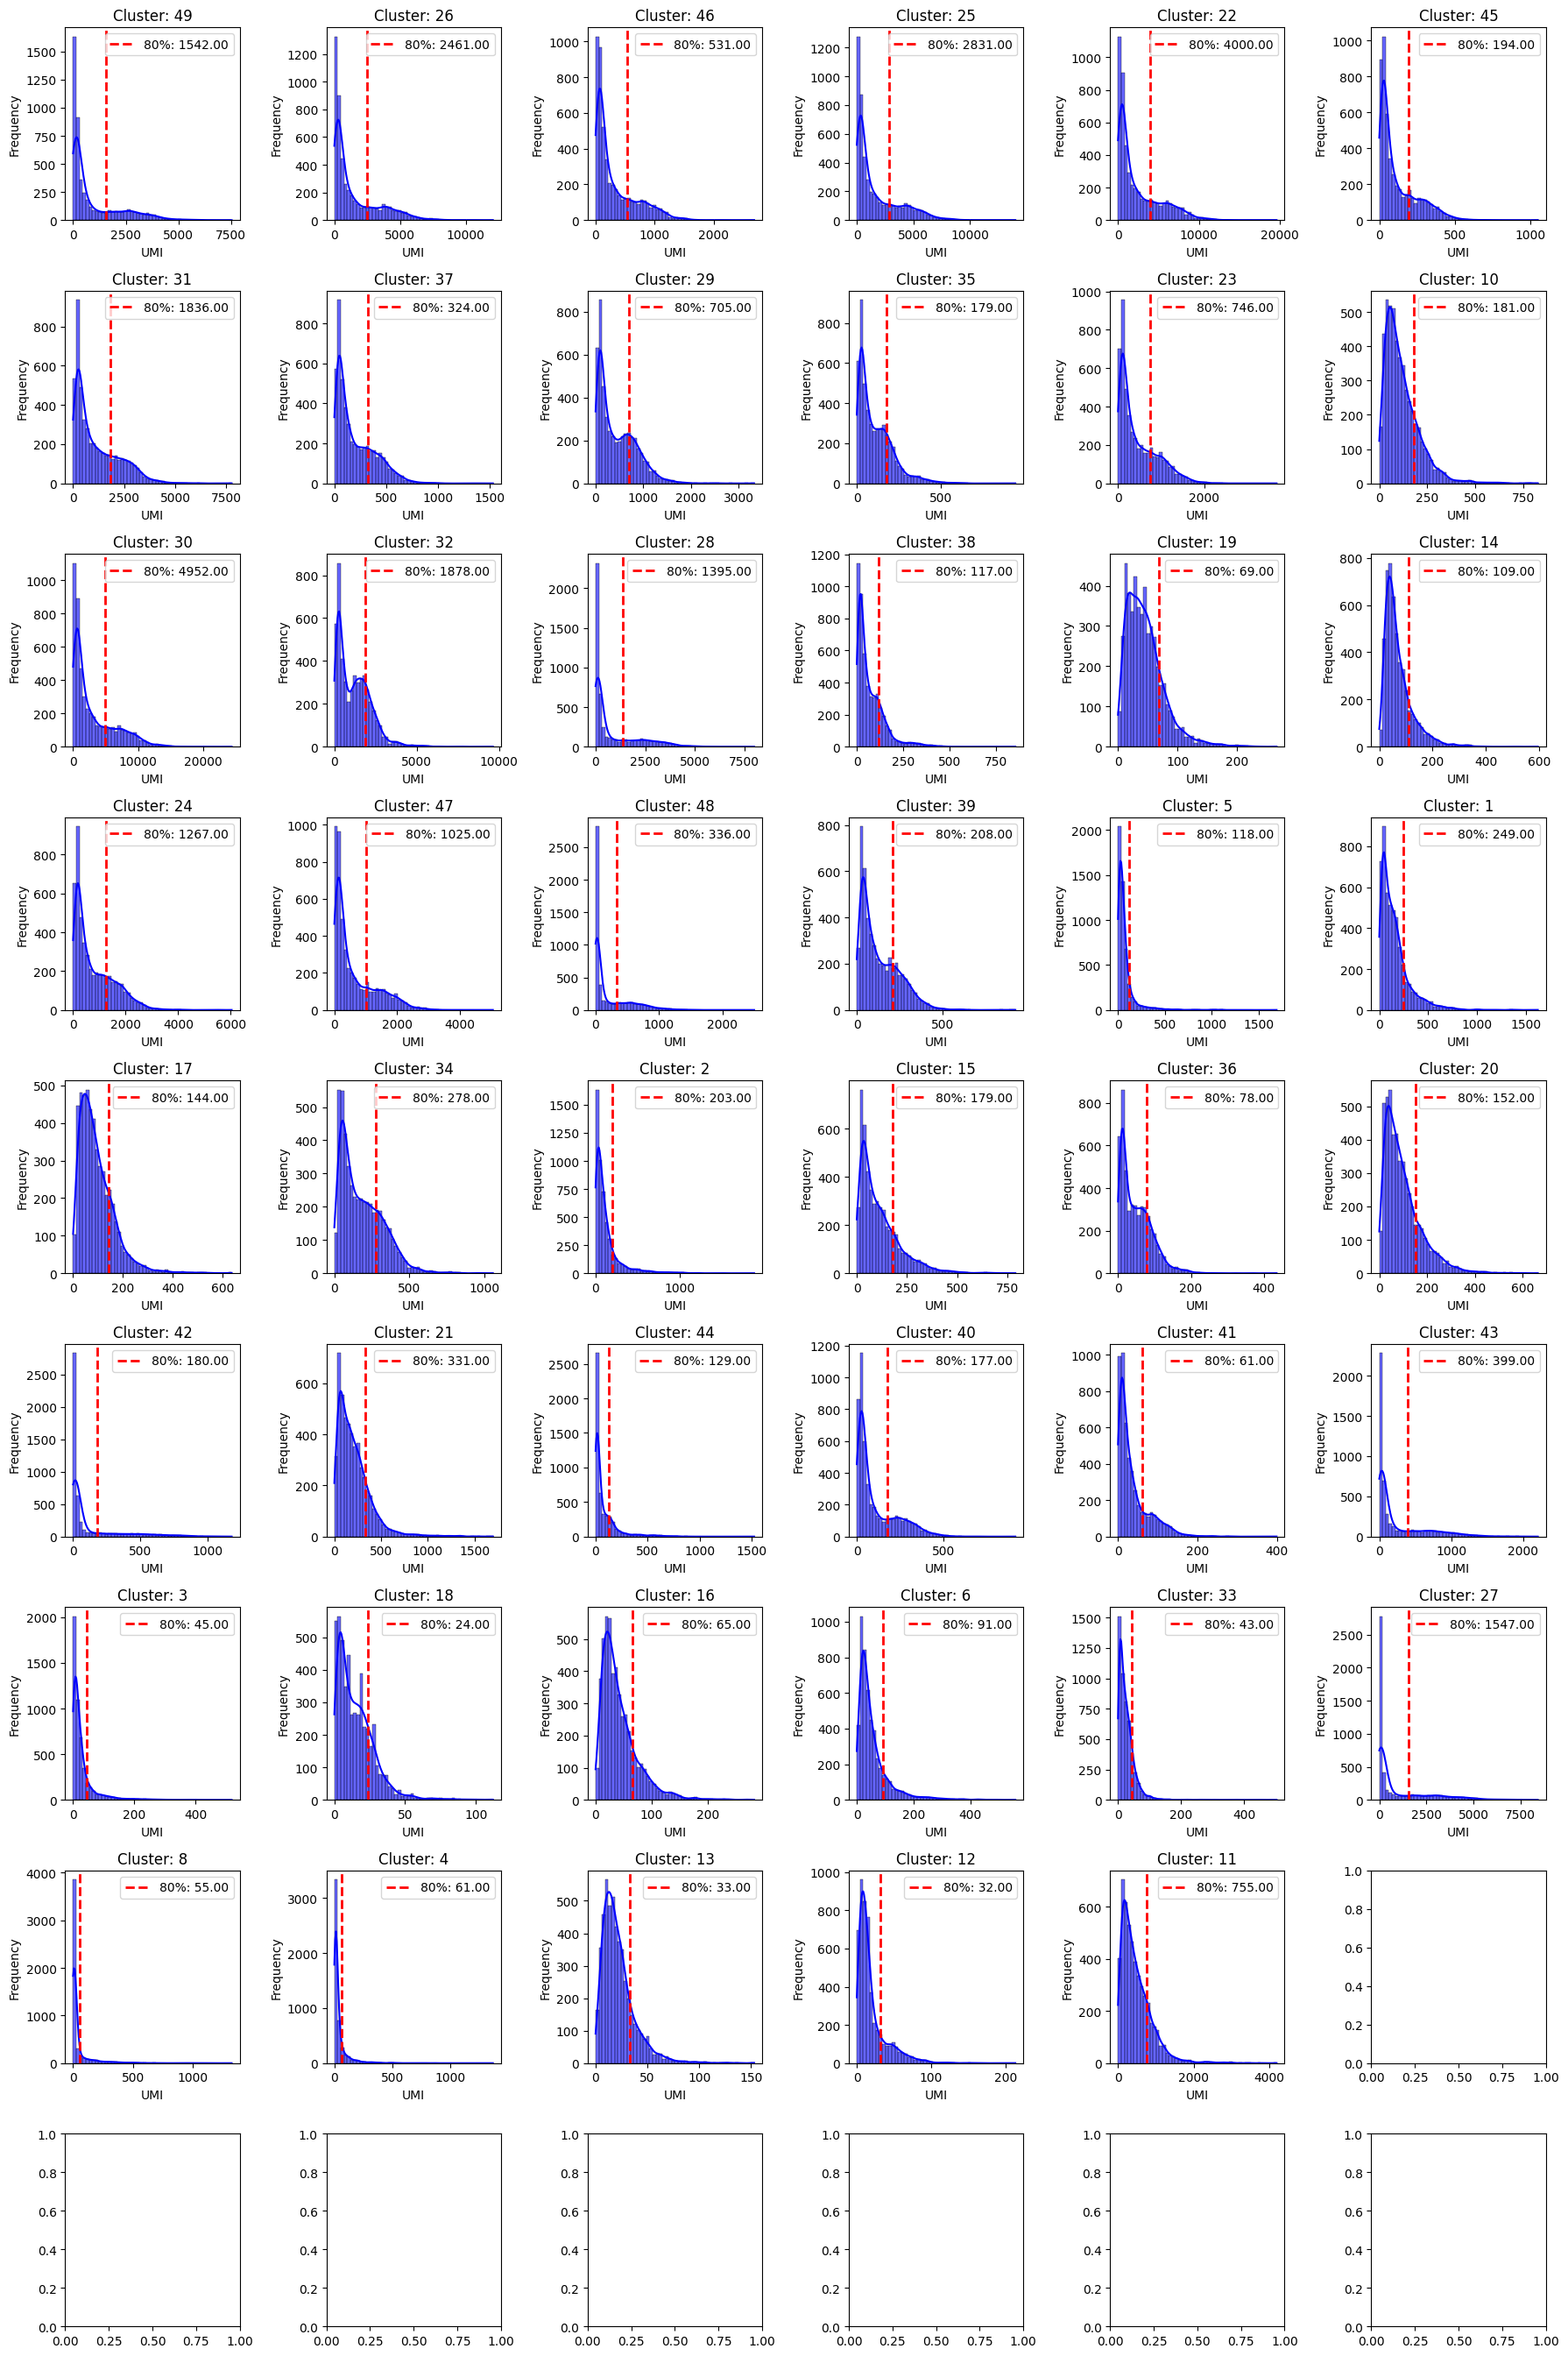

In [12]:
# Plot histograms with percentile threshold lines
fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(18, 27))
axes = axes.flatten()

for i, col in enumerate(df_numeric.columns):
    ax = axes[i]
    sns.histplot(df_numeric[col], bins=50, kde=True, color="blue", edgecolor="black", alpha=0.6, ax=ax)
    ax.axvline(thresholds[col], color="red", linestyle="dashed", linewidth=2, label=f"80%: {thresholds[col]:.2f}")
    ax.set_title(f"Cluster: {col}")
    ax.set_xlabel("UMI")
    ax.set_ylabel("Frequency")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
# thresholds_df.T

In [14]:
# # UMI Th should be placed directly afther the main distrubution or inbetween the two in case of a bi-modal distribution

# updated_th = [25.0,57.0,422.0,25.0,11.0,25.0,17.0,9.0,34.0,50.0,75.0,50.0,34.0,120.0,440.0,548.0,210.0,250.0]

# keys = list(thresholds.keys())

# for k, v in zip(keys, updated_th):
#     thresholds[k] = v

# thresholds_df = pd.DataFrame.from_dict(thresholds, orient="index", columns=["UMI Th"])

# # Plot histograms with percentile threshold lines
# fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(18, 27))
# axes = axes.flatten()

# for i, col in enumerate(df_numeric.columns):
#     ax = axes[i]
#     sns.histplot(df_numeric[col], bins=50, kde=True, color="blue", edgecolor="black", alpha=0.6, ax=ax)
#     ax.axvline(thresholds[col], color="red", linestyle="dashed", linewidth=2, label=f"80%: {thresholds[col]:.2f}")
#     ax.set_title(f"Cluster: {col}")
#     ax.set_xlabel("UMI")
#     ax.set_ylabel("Frequency")
#     ax.legend()

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [15]:
# Calculate putative cell count per spot 
# by replacing the values less than the percentile threshold with 0, counting medians, and dividing by them
thresholds_broadcasted = thresholds_df.reindex(deconvolution.index).values 

deconvolution_filtered = deconvolution.where(deconvolution >= thresholds_broadcasted, 0)

deconvolution_nonzero = deconvolution_filtered.replace(0, np.nan)

cluster_mins = deconvolution_nonzero.min(axis=1, numeric_only=True)+1

cell_count = np.ceil(deconvolution_nonzero.div(cluster_mins, axis=0))

cell_count = cell_count.fillna(0).astype(int)

cell_count.T.sum()

Cluster
49    2899
26    2780
46    2675
25    2746
22    2712
45    2648
31    2664
37    2648
29    2683
35    2372
23    2661
10    2079
30    2697
32    2493
28    3047
38    2333
19    1926
14    1890
24    2666
47    2710
48    3198
39    2571
5     1941
1     1985
17    2077
34    2520
2     2114
15    2211
36    2466
20    2095
42    3206
21    2004
44    2706
40    2725
41    2341
43    3032
3     2175
18    2105
16    1984
6     1938
33    1897
27    3231
8     3713
4     2596
13    1851
12    2003
11    2155
dtype: int64

In [16]:
cells_per_spot = 23 # Set putative meadian cell per spot count
spots = deconvolution.shape[1]

print(f'                       The predicted total cell number is {spots * cells_per_spot}')
print(f'The total cell number observed after the deconvolution is {round(cell_count.T.sum().sum())}')
print(f'                                             The ratio is {(spots * cells_per_spot)/(cell_count.T.sum().sum())}')

                       The predicted total cell number is 114816
The total cell number observed after the deconvolution is 116169
                                             The ratio is 0.9883531751155644


In [17]:
# Call Putative cell clusters per spot

# Precompute mapping
genes = Visium.index.to_list()
gene_to_idx = {g: i for i, g in enumerate(genes)}
n_genes = len(genes)

clusters = df_clusters.index.to_list()
n_clusters = len(clusters)

# Build a boolean mask
cluster_masks = np.zeros((n_genes, n_clusters), dtype=bool)
for c_idx, c in enumerate(clusters):
    for g in df_clusters.at[c, "Genes"]:
        cluster_masks[gene_to_idx[g], c_idx] = True

# Determine nonzero subspots
spots = Visium.columns.to_list()
n_spots = len(spots)

# Make a boolean rule indicating which subspots to keep
keep = cell_count.values > 0  # shape (n_clusters, n_spots)
keep = keep.T                # now (n_spots, n_clusters)

# Build list of (spot,cluster) pairs we will output
subspot_labels = [
    f"{spot}_{clusters[c_idx]}"
    for s_idx, spot in enumerate(spots)
    for c_idx in range(n_clusters)
    if keep[s_idx, c_idx]
]
n_subspots = len(subspot_labels)

# Extract the Visium matrix as ndarray
V = Visium.values 

subspot_data = np.zeros((n_genes, n_subspots), dtype=int)
col = 0
for s_idx in range(n_spots):
    spot_vector = V[:, s_idx].reshape(-1, 1)       

    keep_clusters = np.where(keep[s_idx])[0]      

    masks = cluster_masks[:, keep_clusters]      

    block = (spot_vector * masks).astype(int)

    subspot_data[:, col:col + len(keep_clusters)] = block
    col += len(keep_clusters)

# Wrap into DataFrame
putative_cell_per_spot = pd.DataFrame(
    subspot_data,
    index=genes,
    columns=subspot_labels
)

putative_cell_per_spot

,AACACCTACTATCGAA-1_10,AACACCTACTATCGAA-1_19,AACACCTACTATCGAA-1_14,AACACCTACTATCGAA-1_17,AACACCTACTATCGAA-1_16,AACACCTACTATCGAA-1_13,AACACCTACTATCGAA-1_12,AACACTTGGCAAGGAA-1_31,AACACTTGGCAAGGAA-1_37,AACACTTGGCAAGGAA-1_29,...,TGTTGGATGGACTTCT-1_27,TGTTGGCCTACACGTG-1_10,TGTTGGCCTACACGTG-1_14,TGTTGGCCTACACGTG-1_17,TGTTGGCCTACACGTG-1_20,TGTTGGCCTACACGTG-1_16,TGTTGGCCTACACGTG-1_33,TGTTGGCCTACACGTG-1_13,TGTTGGCCTACACGTG-1_12,TGTTGGCCTACACGTG-1_11
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KLHL17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PLEKHN1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HES4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBP1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RAB39B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CLIC2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TMLHE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Call putative cells per cluster per spot

CHUNK_SIZE    = 1000
PARQUET_DIR   = "putative_cell_chunks"

if os.path.exists(PARQUET_DIR):
    for f in glob.glob(os.path.join(PARQUET_DIR, "*.parquet")):
        os.remove(f)
else:
    os.makedirs(PARQUET_DIR)

cell_count.index   = cell_count.index.astype(str)
cell_count.columns = cell_count.columns.astype(str)

pcps           = putative_cell_per_spot
genes          = pcps.index.to_list()
n_genes        = len(genes)
putative_cells = pcps.columns.to_list()
n_cells        = len(putative_cells)

pairs   = [pc.split("_",1) for pc in putative_cells]
spots   = [p[0] for p in pairs]
clusters= [p[1] for p in pairs]

# precompute how many putative‐cells there are per column
counts = np.array([
    int(np.ceil(cell_count.at[cl, sp])) if (cl in cell_count.index and sp in cell_count.columns) else 0
    for sp, cl in zip(spots, clusters)
], dtype=int)

for start in range(0, n_cells, CHUNK_SIZE):
    end      = min(start + CHUNK_SIZE, n_cells)
    idxs     = range(start, end)
    cols     = putative_cells[start:end]
    block    = pcps.iloc[:, idxs].values.astype(int)
    local_ct = counts[idxs]

    # splits
    splits = np.zeros_like(block, dtype=int)
    mz     = local_ct > 0
    splits[:, mz] = np.ceil(block[:, mz] / local_ct[mz]).astype(int)

    # build chunk
    block_list = []
    out_cols   = []
    for li, gi in enumerate(idxs):
        c = local_ct[li]
        if c <= 0: 
            continue
        vec   = splits[:, li].reshape(n_genes, 1)
        chunk = np.repeat(vec, c, axis=1)
        block_list.append(chunk)
        base = putative_cells[gi]
        for i in range(1, c+1):
            out_cols.append(f"{base}_{i}")

    if not block_list:
        continue

    arr      = np.hstack(block_list)
    df_chunk = pd.DataFrame(arr, index=genes, columns=out_cols)
    df_chunk = df_chunk.loc[:, df_chunk.sum(axis=0) != 0]        
    df_chunk = df_chunk[~df_chunk.index.duplicated(keep="first")] 
    df_chunk = df_chunk.astype(str)                             

    fn = os.path.join(PARQUET_DIR, f"chunk_{start}_{end}.parquet")
    df_chunk.to_parquet(fn)

    # free memory
    del block, splits, df_chunk, arr, block_list

parquet_files = sorted(glob.glob(os.path.join(PARQUET_DIR, "chunk_*.parquet")))
df_list = [pd.read_parquet(f) for f in parquet_files]
putative_cell_df = pd.concat(df_list, axis=1)

putative_cell_df

,AACACCTACTATCGAA-1_10_1,AACACCTACTATCGAA-1_10_2,AACACCTACTATCGAA-1_19_1,AACACCTACTATCGAA-1_19_2,AACACCTACTATCGAA-1_14_1,AACACCTACTATCGAA-1_14_2,AACACCTACTATCGAA-1_17_1,AACACCTACTATCGAA-1_17_2,AACACCTACTATCGAA-1_16_1,AACACCTACTATCGAA-1_16_2,...,ATAGTTCGCAGCCGTG-1_1_2,ATAGTTCGCAGCCGTG-1_17_1,ATAGTTCGCAGCCGTG-1_17_2,ATAGTTCGCAGCCGTG-1_2_1,ATAGTTCGCAGCCGTG-1_2_2,ATAGTTCGCAGCCGTG-1_2_3,ATAGTTCGCAGCCGTG-1_36_1,ATAGTTCGCAGCCGTG-1_36_2,ATAGTTCGCAGCCGTG-1_20_1,ATAGTTCGCAGCCGTG-1_20_2
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KLHL17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PLEKHN1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HES4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBP1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RAB39B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CLIC2,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
TMLHE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
import json
import math

# Load the JSON file
with open("./spatial/scalefactors_json.json", "r") as file:
    scalefactors = json.load(file)

# Extract and round up the spot radius
SPOT_RADIUS = math.ceil(scalefactors["spot_diameter_fullres"])
SPOT_RADIUS

128

In [20]:
# Randomly allocate the Putative cells within their spots

MIN_DISTANCE = SPOT_RADIUS/15*6

# Group putative cells by their spot barcode
cols = putative_cell_df.columns
spot_ids = [c.split("_",1)[0] for c in cols]
spot_to_cells = {}
for col, spot in zip(cols, spot_ids):
    spot_to_cells.setdefault(spot, []).append(col)

# Prepare tissue_positions_data for fast lookup
tp = tissue_positions_data.copy()
tp.index   = tp.index.map(str)
tp.columns = tp.columns.map(str)

# Build spot 
centers = {
    spot: (tp.at[spot,"pxl_row_in_fullres"], tp.at[spot,"pxl_col_in_fullres"])
    for spot in spot_to_cells
    if spot in tp.index
}

putative_cell_spatial = {}

for spot, cell_cols in spot_to_cells.items():
    if spot not in centers:
        continue
    cx, cy = centers[spot]
    N = len(cell_cols)
    if N == 0:
        continue

    # oversample candidates
    M = max(N*3, N+1)
    u = np.random.rand(M)
    r = SPOT_RADIUS * np.sqrt(u)
    theta = 2*np.pi*np.random.rand(M)
    xs = cx + r*np.cos(theta)
    ys = cy + r*np.sin(theta)

    selected = []
    for x,y in zip(xs,ys):
        if len(selected) >= N:
            break
        if all((x-sx)**2 + (y-sy)**2 >= MIN_DISTANCE**2 for sx,sy in selected):
            selected.append((x,y))

    # if still short, fill with unconstrained
    while len(selected) < N:
        ang = 2*np.pi*np.random.rand()
        rad = SPOT_RADIUS * np.sqrt(np.random.rand())
        x = cx + rad*np.cos(ang)
        y = cy + rad*np.sin(ang)
        selected.append((x,y))

    for col_name, (x,y) in zip(cell_cols, selected):
        putative_cell_spatial[col_name] = (x,y)

# Cell location data export
pcs = pd.DataFrame.from_dict(
    putative_cell_spatial,
    orient="index",
    columns=["center_x","center_y"]
)

pcs.to_csv("cell_metadata.csv")

In [21]:
# GEX matrix export in the 10X format
import gzip
import scipy.sparse as sp
from scipy import io

out_dir = "deconvolved_feature_bc_matrix"
os.makedirs(out_dir, exist_ok=True)

arr = putative_cell_df.values.astype(int)
# arr = putative_cell_per_spot.values.astype(int) # Use for DGE - UMI counts are not split between the putative cells

mat = sp.csr_matrix(arr)

with gzip.open(os.path.join(out_dir, "matrix.mtx.gz"), "wb") as f:
    io.mmwrite(f, mat)

with gzip.open(os.path.join(out_dir, "barcodes.tsv.gz"), "wt") as f:
    for cell in putative_cell_df.columns:
        f.write(cell + "\n")

with gzip.open(os.path.join(out_dir, "features.tsv.gz"), "wt") as f:
    for gene in putative_cell_df.index:
        f.write(f"{gene}\t{gene}\tgene\n")

In [22]:
# Cluster info export
cluster_df = pcs.index.str.extract(r'-1_(\d+)_')
cluster_df = cluster_df.rename(columns={0: 'Cluster'})
cluster_df.index = pcs.index
cluster_df.to_csv('cluster_info.csv')
cluster_df.head()
b = time.time()

In [23]:
print(f'It took {(b - a)/60} minutes')

It took 8.27027334769567 minutes
